<div align="center" style="font-size:50px; color: blue; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
DEMO GRAPH NEURAL NETWORK WITH CITESEER DATASET
</div>

<div align="left" style="font-size:30px; color: green; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
I. Import library
</div>

In [13]:
import torch
import numpy as np
np.random.seed(0)

import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from torch_geometric.datasets import Planetoid

from torch_geometric.utils import to_networkx

import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv

from torch_geometric.loader import NeighborLoader
import matplotlib.pyplot as plt
import collections
import seaborn as sns

<div align="left" style="font-size:30px; color: green; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
II. Import dataset
</div>

In [35]:
# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="PubMed")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: PubMed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


<div align="left" style="font-size:30px; color: green; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
III. Plot data
</div>

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


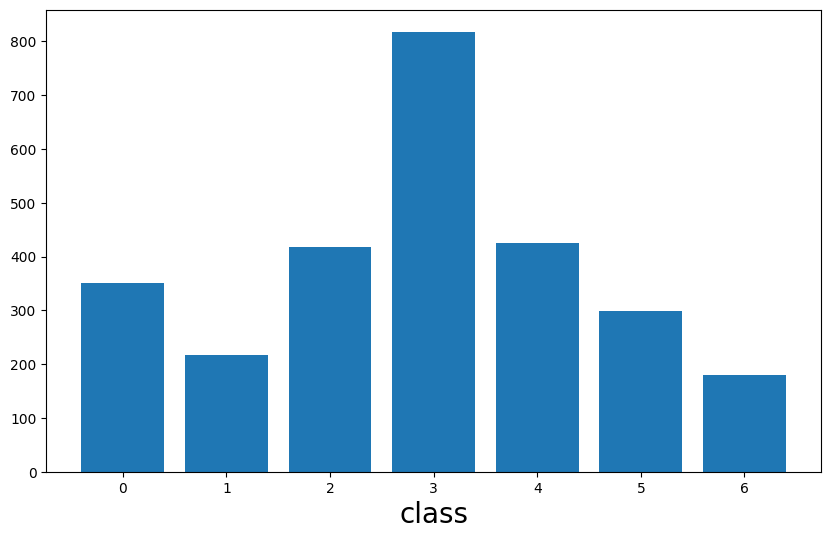

In [8]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

In [36]:
label_dict = {
    0: "1",
    1: "2",
    2: "3"
    }

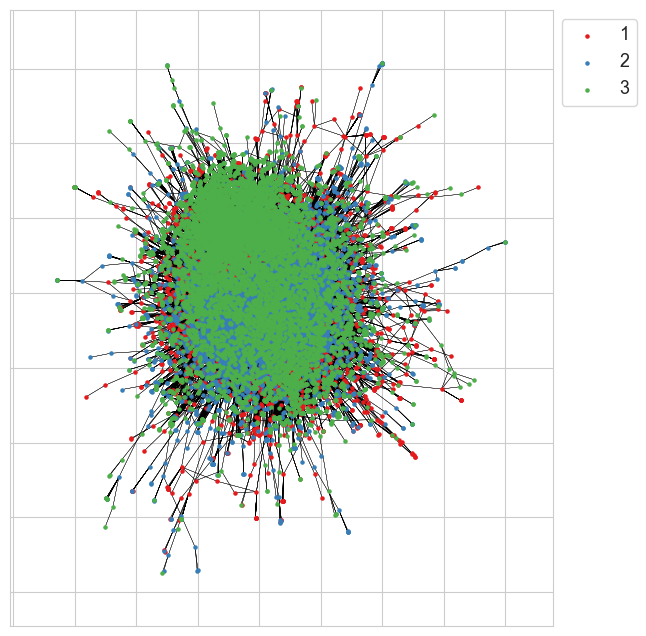

In [37]:
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (7, 8))
labellist = list(label_dict.values())

for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
    nx.draw_networkx_edges(G, pos, width = 0.2)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Cora.png', dpi=300)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10076\225764783.py:27: RuntimeWarning: invalid value encountered in true_divide
  return array / sum(array)


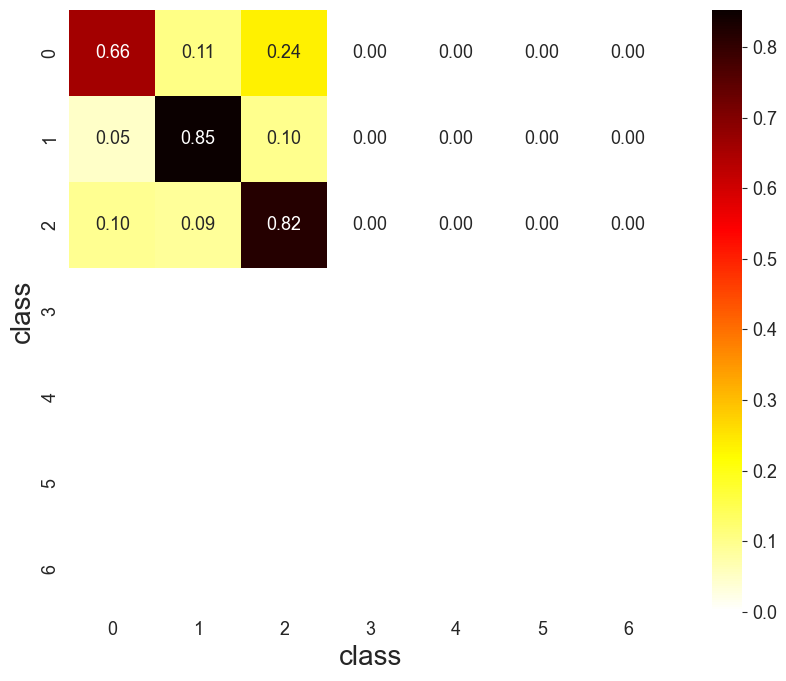

In [15]:
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)

def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter
label_connection_counts = []
for i in range(7):
    # print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    # print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    # print(counter)
    counter = add_missing_keys(counter, range(7))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)
label_connection_counts = np.array(label_connection_counts)

label_connection_counts.diagonal().sum() / label_connection_counts.sum()

def scaling(array):
    return array / sum(array)
    
label_connection_counts_scaled = np.apply_along_axis(scaling, 1, label_connection_counts)

plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='hot_r',
    fmt="1.2f",
    cbar=True,
    square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()
# plt.figure(figsize=(9, 7))
# plt.rcParams["font.size"] = 13
# hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
# plt.xlabel("class",size=20)
# plt.ylabel("class",size=20)
# plt.tight_layout()
# plt.show()

threshold 0.0039054574964495843


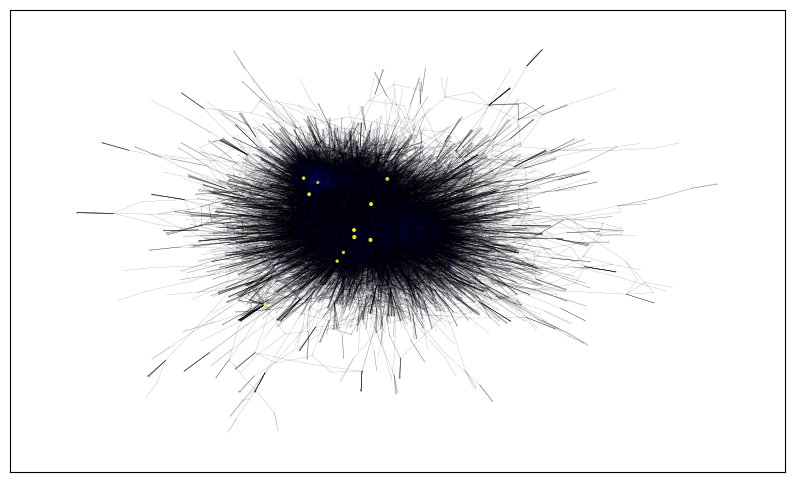

<Figure size 640x480 with 0 Axes>

In [42]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(10, 6))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()
plt.savefig('CiteSeer.png', bbox_inches='tight')

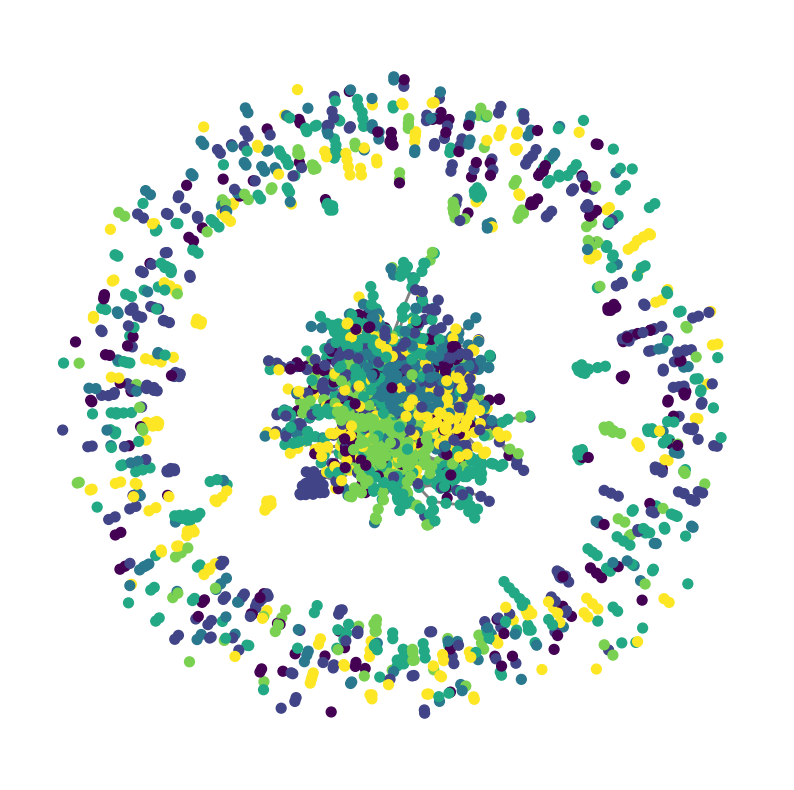

<Figure size 640x480 with 0 Axes>

In [32]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10,10))
plt.axis('off')
nx.draw_networkx(G, 
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()
plt.savefig('CiteSeer.png', bbox_inches='tight')

<div align="left" style="font-size:30px; color: green; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
IV. Plot node degrees
</div>

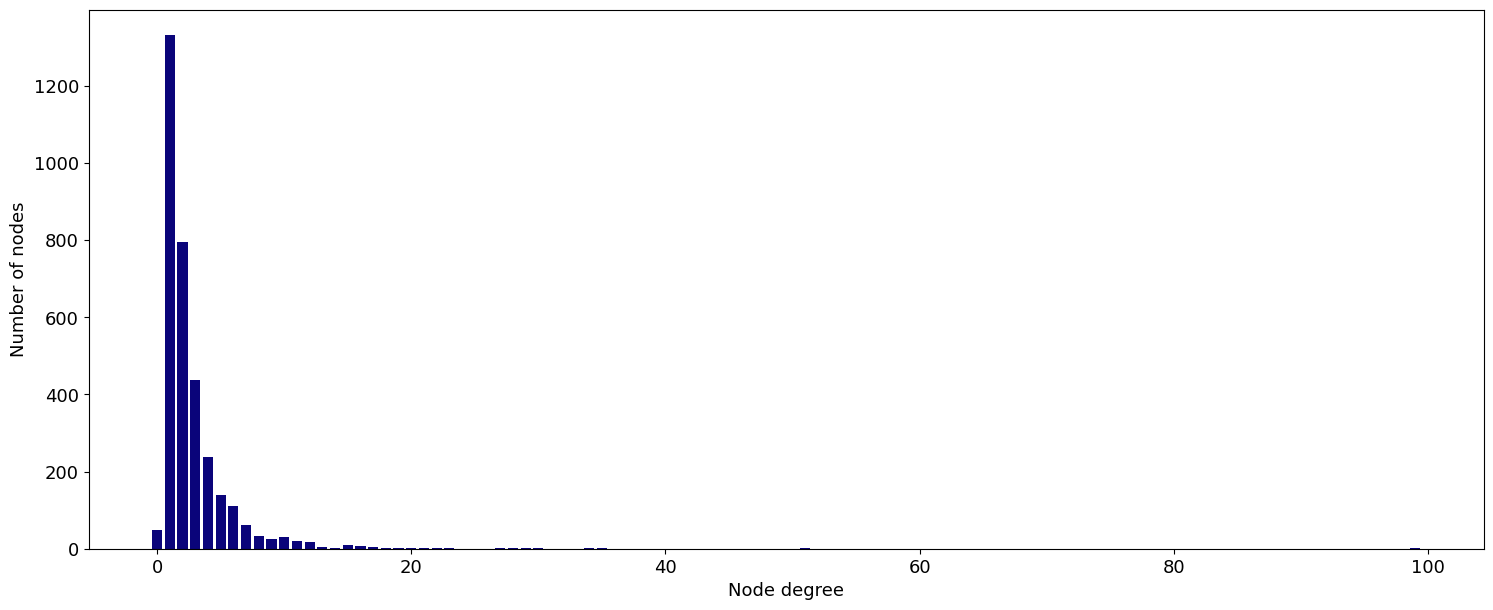

In [31]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')
plt.savefig('CiteSeer.png', bbox_inches='tight')

<div align="left" style="font-size:30px; color: green; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
V. Create batches with neighbor sampling
</div>

In [3]:
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

<div align="left" style="font-size:30px; color: green; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
VI. Calculate accuracy and evaluate the model on test set and print the accuracy score
</div>

In [4]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

<div align="left" style="font-size:30px; color: green; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
VII. Construction model
</div>

In [5]:
train_acc_all_gcn = []
train_acc_all_gat = []
train_acc_all_gsea = []

<div align="left" style="font-size:25px; color: red; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
1. Graph Convolutional Network
</div>

In [9]:
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_h)
    self.gcn3 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer
    print(data)
    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])
        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            train_acc_all_gcn.append(acc)
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
            


<div align="left" style="font-size:25px; color: red; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
2. GraphSAGE
</div>

In [47]:
class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        _, out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1),
                        batch.y[batch.train_mask])
        
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          train_acc_all_gsea.append(acc/len(train_loader))
          print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

<div align="left" style="font-size:25px; color: red; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
3. Graph Attention Network
</div>

In [48]:
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            train_acc_all_gat.append(acc)
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

<div align="left" style="font-size:30px; color: green; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
VIII. Implement model
</div>

<div align="left" style="font-size:25px; color: red; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
1. Graph Convolutional Network
</div>

In [10]:
%%time
# Create GCN
gcn = GCN(dataset.num_features, 64, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, 200)

# Test
print(f'\nGCN test accuracy: {test(gcn, data)*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 64)
  (gcn2): GCNConv(64, 64)
  (gcn3): GCNConv(64, 6)
)
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Epoch   0 | Train Loss: 4.176 | Train Acc:   0.00% | Val Loss: 4.18 | Val Acc: 0.20%
Epoch  10 | Train Loss: 0.244 | Train Acc:  96.67% | Val Loss: 1.14 | Val Acc: 58.60%
Epoch  20 | Train Loss: 0.100 | Train Acc:  96.67% | Val Loss: 1.46 | Val Acc: 56.80%
Epoch  30 | Train Loss: 0.027 | Train Acc: 100.00% | Val Loss: 1.51 | Val Acc: 59.60%
Epoch  40 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 1.45 | Val Acc: 61.20%
Epoch  50 | Train Loss: 0.032 | Train Acc: 100.00% | Val Loss: 1.39 | Val Acc: 62.40%
Epoch  60 | Train Loss: 0.023 | Train Acc: 100.00% | Val Loss: 1.43 | Val Acc: 60.60%


KeyboardInterrupt: 

<div align="left" style="font-size:25px; color: red; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
2. GraphSAGE
</div>

In [50]:
%%time
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(3703, 64, aggr=mean)
  (sage2): SAGEConv(64, 6, aggr=mean)
)
Epoch   0 | Train Loss: 0.231 | Train Acc:  34.31% | Val Loss: 1.70 | Val Acc: 40.14%
Epoch  10 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.54 | Val Acc: 47.76%
Epoch  20 | Train Loss: 0.001 | Train Acc:  99.46% | Val Loss: 1.69 | Val Acc: 55.60%
Epoch  30 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.81 | Val Acc: 49.21%
Epoch  40 | Train Loss: 0.000 | Train Acc:  98.88% | Val Loss: 1.61 | Val Acc: 51.85%
Epoch  50 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 2.90 | Val Acc: 49.44%
Epoch  60 | Train Loss: 0.041 | Train Acc:  96.97% | Val Loss: 2.74 | Val Acc: 55.52%
Epoch  70 | Train Loss: 0.000 | Train Acc:  99.40% | Val Loss: 3.03 | Val Acc: 54.25%
Epoch  80 | Train Loss: 0.000 | Train Acc:  99.40% | Val Loss: 3.54 | Val Acc: 48.00%
Epoch  90 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 3.36 | Val Acc: 52.55%
Epoch 100 | Train Loss: 0.000 | Train Acc: 100.0

<div align="left" style="font-size:25px; color: red; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
3. Graph Attention Network
</div>

In [51]:
%%time
# Create GAT
gat = GAT(dataset.num_features, 64, dataset.num_classes)
print(gat)

# Train
gat.fit(data, 200)

# Test
print(f'\nGAT test accuracy: {test(gat, data)*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(3703, 64, heads=8)
  (gat2): GATv2Conv(512, 6, heads=8)
)
Epoch   0 | Train Loss: 3.844 | Train Acc:   2.50% | Val Loss: 3.86 | Val Acc: 1.80%
Epoch  10 | Train Loss: 0.011 | Train Acc: 100.00% | Val Loss: 1.31 | Val Acc: 64.80%
Epoch  20 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.49 | Val Acc: 64.40%
Epoch  30 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.36 | Val Acc: 64.00%
Epoch  40 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 1.22 | Val Acc: 67.80%
Epoch  50 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 1.14 | Val Acc: 67.20%
Epoch  60 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.09 | Val Acc: 66.80%
Epoch  70 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.03 | Val Acc: 68.60%
Epoch  80 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.05 | Val Acc: 68.80%
Epoch  90 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.07 | Val Acc: 68.00%
Epoch 100 | Train Loss: 0.004 | Train Acc: 100.00% | Val L

### Plot model

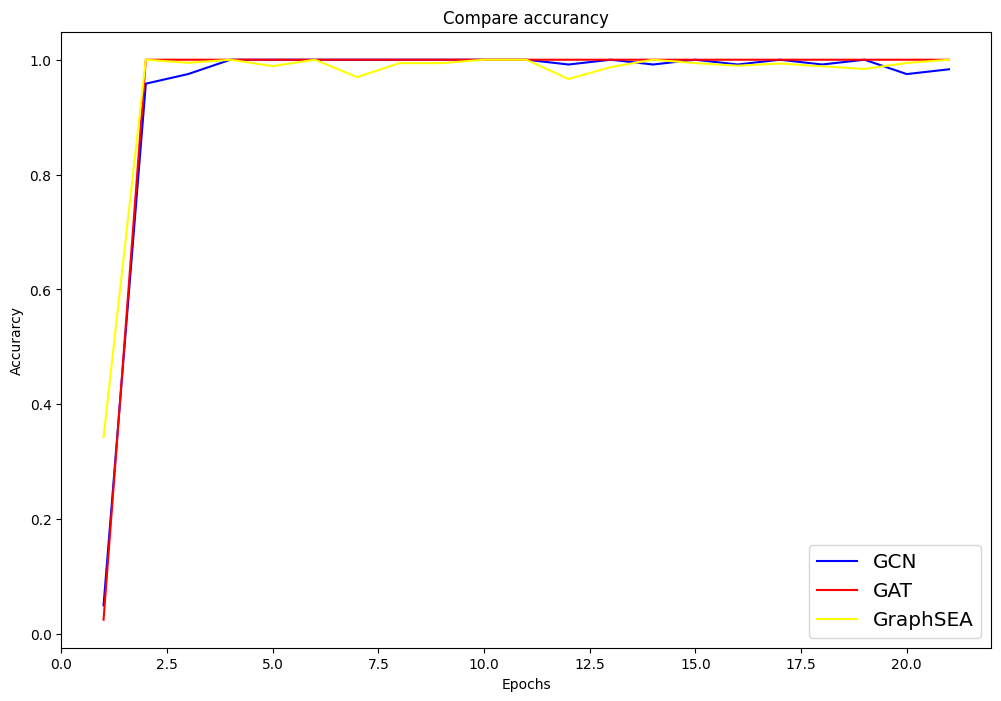

In [52]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(train_acc_all_gcn) + 1), train_acc_all_gcn, label='GCN', c='blue')
plt.plot(np.arange(1, len(train_acc_all_gat) + 1), train_acc_all_gat, label='GAT', c='red')
plt.plot(np.arange(1, len(train_acc_all_gsea) + 1), train_acc_all_gsea, label='GraphSEA', c='yellow')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('Compare accurancy')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_gcn_loss.png')
plt.show()

In [53]:
print(len(train_acc_all_gsea))

21


In [54]:
for i in range(0,len(train_acc_all_gsea)):
    if(train_acc_all_gsea[i]>1):
        print(train_acc_all_gsea[i])

In [55]:
train_acc_all_gsea

[0.34309947583824396,
 1.0,
 0.9945652186870575,
 1.0,
 0.9888392835855484,
 1.0,
 0.9697420597076416,
 0.9940476194024086,
 0.9940476194024086,
 1.0,
 1.0,
 0.9664324149489403,
 0.9871710538864136,
 1.0,
 0.9940476194024086,
 0.9895833358168602,
 0.9934210553765297,
 0.9885416626930237,
 0.9839015156030655,
 0.9943181797862053,
 1.0]

In [11]:
import torch
import numpy as np

# Your list of PyTorch tensors
tensor_list = [torch.tensor(4.1503, requires_grad=True), torch.tensor(1.3366, requires_grad=True),
               torch.tensor(1.2910, requires_grad=True), torch.tensor(1.3815, requires_grad=True),
               torch.tensor(1.4702, requires_grad=True)]

# Convert the list of PyTorch tensors to a NumPy array
numpy_array = np.array([tensor.item() for tensor in tensor_list])

<div align="center" style="font-size:50px; color: blue; font-weight: bold; font-family: 'Times New Roman', Times, serif;">
END
</div>

In [2]:
import pandas as pd
import os

from stellargraph import datasets
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

# from tensorflow.keras import layers, optimizers, losses, metrics, Model
import matplotlib.pyplot as plt
# %matplotlib inline

In [8]:
dataset = datasets.PubMedDiabetes()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [9]:
data=node_subjects.value_counts()

In [10]:
df = data.reset_index()
df.columns = ['subject', 'count']

# Print the resulting DataFrame
print(df)

   subject  count
0        2   7875
1        3   7739
2        1   4103


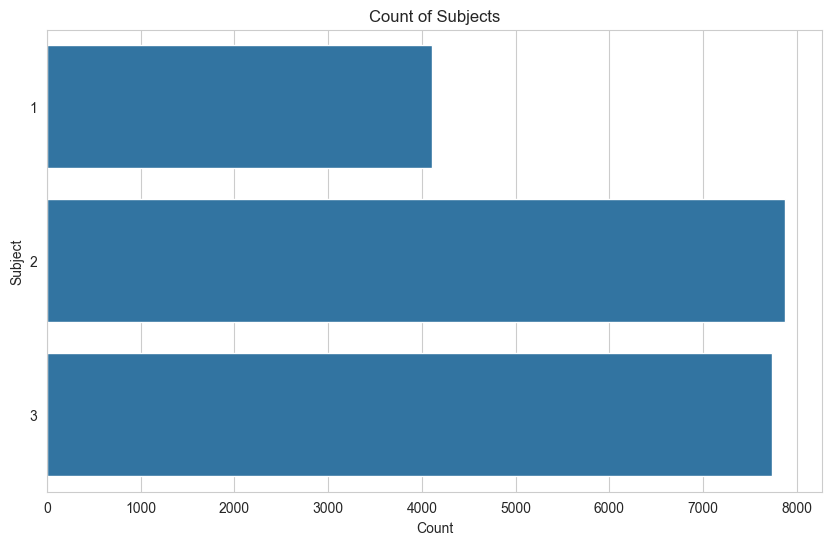

In [11]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='count', y='subject', orient='h')
plt.title('Count of Subjects')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.show()

In [12]:
df['subject'].value_counts()

2    1
3    1
1    1
Name: subject, dtype: int64

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# df = pd.DataFrame(data)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 10))
sns.countplot(data=df, y='subject', order=df['subject'].value_counts().index())
plt.title('fdsef')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.show()

TypeError: 'Index' object is not callable

<Figure size 1000x1000 with 0 Axes>

In [38]:
from PIL import Image

image = Image.open('./assets/img/backfround.jpg')
new_image = image.resize((500, 500))
new_image.save('myimage_500.jpg')